# Imports

In [1]:
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from PIL import Image
import sqlite3
import numpy as np
import torchvision.transforms as transforms
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from torchvision.models import resnet18

# Create the Siamese Network Class

In [2]:
class SiameseNetwork(nn.Module):
    def __init__(self, pretrained_model):
        super(SiameseNetwork, self).__init__()
        # Load the pretrained model
        self.pretrained_model = pretrained_model
        # Replace the last fully connected layer with an identity layer
        self.pretrained_model.fc = nn.Identity()

    def forward_once(self, x):
        # Forward pass through the pretrained model
        output = self.pretrained_model(x)
        return output

    def forward(self, input1, input2):
        # Forward pass for both inputs through the pretrained model
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2

# Initialize the model and network

In [3]:
# Load the pretrained ResNet18 model
pretrained_resnet = models.resnet18(weights='DEFAULT')
# Create the Siamese network instance
siamese_net = SiameseNetwork(pretrained_model=pretrained_resnet)

# Set dataset path

In [4]:
dataset_path = 'post-processed-celebs'


# Create the Custom Dataset class

In [5]:
class CustomDataset(ImageFolder):
    def __init__(self, root, transform=None):
        super(CustomDataset, self).__init__(root, transform=transform)

    # Method to retrieve items from the dataset given an index
    def __getitem__(self, index):
        # Retrieve the path for the image at the specified index
        image_path, _ = self.samples[index]
        image = Image.open(image_path)
        # Apply transformations to the image if transform is specified
        if self.transform is not None:
            image = self.transform(image)
        return image, image_path

dataset = CustomDataset(dataset_path, transform=ToTensor())
batch_size = 64
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

# Perform inference

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
siamese_net.to(device)

# Set the model to evaluation mode
siamese_net.eval()

# Initialize lists to store descriptor vectors and file paths
descriptor_vectors = []
file_paths = []

# Iterate through batches in the data loader
for batch in data_loader:
    images, paths = batch
    images = images.to(device)
    with torch.no_grad():
        # Forward pass through the Siamese network with image pairs
        outputs = siamese_net(images, images)
    descriptor_vectors.extend(outputs[0].cpu().numpy())
    file_paths.extend(paths)

# Merge file path and descriptor vector

In [7]:
descriptor_vectors_with_paths = list(zip(descriptor_vectors, file_paths))

# Set up database and create table

In [8]:
# Connect to SQLite database
conn = sqlite3.connect('full_database.db')
cursor = conn.cursor()

# Create a table to store image paths and descriptor vectors
cursor.execute('''CREATE TABLE IF NOT EXISTS ImageDescriptors
                  (id INTEGER PRIMARY KEY,
                   file_path TEXT,
                   descriptor_vector BLOB)''')

# Insert images and descriptor vectors

In [9]:
# Insert data into the table
for descriptor, file_path in descriptor_vectors_with_paths:
    cursor.execute("INSERT INTO ImageDescriptors (file_path, descriptor_vector) VALUES (?, ?)", (file_path, descriptor.tobytes()))

# Commit changes and close the connection
conn.commit()
conn.close()

print("Database created and populated.")

Database created and populated.


# Add image of me without a mask


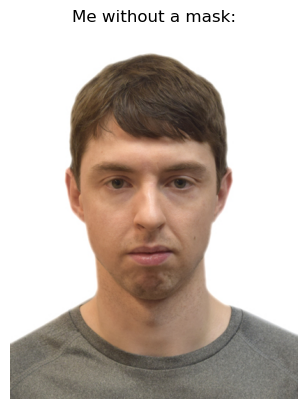

Image added to the database with its descriptor vector.


In [10]:
# Load the image
image_path = 'withoutMask.jpg'
image = Image.open(image_path)

# Display the image
plt.imshow(image)
plt.title(f'Me without a mask:')
plt.axis('off')  # Turn off axis labels and ticks
plt.show()

# Convert the image to a tensor
transform = transforms.ToTensor()
image_tensor = transform(image).unsqueeze(0)  # Add batch dimension

# Move the image tensor to the appropriate device (CPU/GPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
image_tensor = image_tensor.to(device)

# Pass the image tensor through your Siamese network to get the descriptor vector
with torch.no_grad():
    descriptor_vector = siamese_net.forward_once(image_tensor)

# Convert the descriptor vector to bytes
descriptor_bytes = descriptor_vector.cpu().numpy().tobytes()

# Connect to SQLite database
conn = sqlite3.connect('full_database.db')
cursor = conn.cursor()

# Insert the image path and descriptor vector into the database
cursor.execute("INSERT INTO ImageDescriptors (file_path, descriptor_vector) VALUES (?, ?)", (image_path, descriptor_bytes))

# Commit changes and close the connection
conn.commit()
conn.close()

print("Image added to the database with its descriptor vector.")


# Verify image

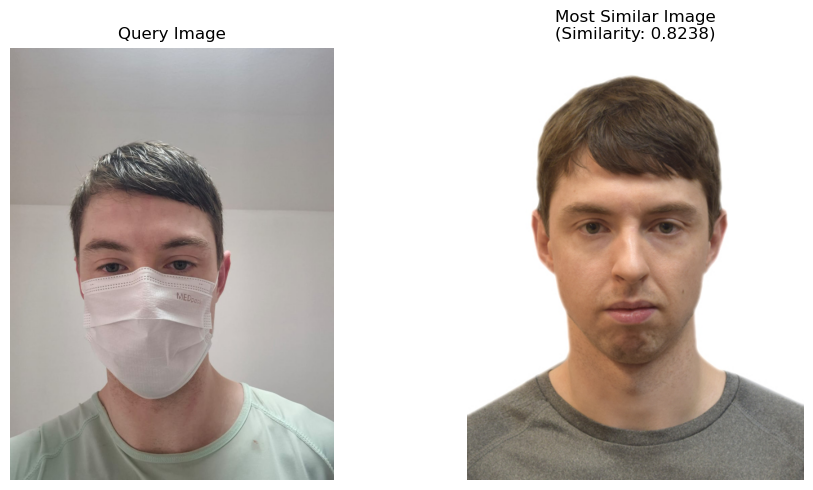

In [12]:
# Load the new image
query_image_path = 'withMask.jpg'
query_image = Image.open(query_image_path)

# Convert the query image to a tensor
transform = transforms.ToTensor()
query_image_tensor = transform(query_image).unsqueeze(0)  # Add batch dimension

# Move the query image tensor to the appropriate device (CPU/GPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
query_image_tensor = query_image_tensor.to(device)

# Pass the query image tensor through the Siamese network to get its descriptor vector
with torch.no_grad():
    query_descriptor_vector = siamese_net.forward_once(query_image_tensor)

# Convert the query descriptor vector to numpy array for similarity calculation
query_descriptor_np = query_descriptor_vector.cpu().numpy()

# Connect to SQLite database
conn = sqlite3.connect('full_database.db')
cursor = conn.cursor()

# Retrieve all descriptor vectors from the database
cursor.execute("SELECT file_path, descriptor_vector FROM ImageDescriptors")
rows = cursor.fetchall()

# Calculate cosine similarity with each descriptor vector in the database
similar_images = []
for row in rows:
    file_path, descriptor_bytes = row
    descriptor_np = np.frombuffer(descriptor_bytes, dtype=np.float32)
    descriptor_np = descriptor_np.reshape((1, -1))  # Reshape to match the query descriptor shape
    similarity = cosine_similarity(query_descriptor_np, descriptor_np)
    similar_images.append((file_path, similarity[0][0]))

# Sort similar images by similarity score (descending order)
similar_images.sort(key=lambda x: x[1], reverse=True)

# Display the query image and the most similar image side by side
if similar_images:
    top_image_path = similar_images[0][0]
    top_similarity = similar_images[0][1]
    top_image = Image.open(top_image_path)

    # Create a figure with two subplots side by side
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    
    # Display the query image
    axes[0].imshow(query_image)
    axes[0].axis('off')
    axes[0].set_title("Query Image")
    
    # Display the most similar image
    axes[1].imshow(top_image)
    axes[1].axis('off')
    axes[1].set_title(f"Most Similar Image\n(Similarity: {top_similarity:.4f})")
    
    plt.tight_layout()
    plt.show()
else:
    print("No similar images found.")

# Close the connection
conn.close()